In [14]:
import nltk
import whisper
import numpy as np
from sklearn.linear_model import LinearRegression
from src.data.dataset import CommonVoice

In [16]:
#!pip install git+https://github.com/openai/whisper.git

In [17]:
model = whisper.load_model("small")
ds_test = CommonVoice("test")

In [35]:
x, y = ds_test[40]

In [36]:
ds_test.vocab.decode(y.numpy())

'they perfectly illuminate the flowerbeds of gardens . <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [37]:
audio = whisper.pad_or_trim(x.numpy())
result = model.transcribe(audio)["text"]

/Users/diego/dev/BATS/.venv/lib/python3.10/site-packages/whisper/transcribe.py:115: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


In [38]:
# Define the function to transcribe audio using Whisper
def transcribe(audio):
    audio = whisper.pad_or_trim(audio)  # Make sure the audio is the right length
    result = model.transcribe(audio)
    return result['text']

# Define the function to segment audio
def segment_audio(audio, segment_length_ms, sample_rate):
    segment_length = int((segment_length_ms / 1000) * sample_rate)
    return np.array_split(audio, np.arange(segment_length, len(audio), segment_length))

# Define the function to apply mask
def apply_mask(segments, mask):
    masked_audio = np.concatenate([seg if m else np.zeros_like(seg) for seg, m in zip(segments, mask)])
    return masked_audio

# Load your audio data
audio_data = x.numpy()  # Replace with your actual audio data as a NumPy array
sample_rate = 16_000  # Replace with the sample rate of your audio data
segment_length_ms = 100  # Length of each audio segment in milliseconds

# Segment the audio
segments = segment_audio(audio_data, segment_length_ms, sample_rate)

# Get the original transcription
original_transcription = transcribe(audio_data)

In [39]:
# Generate perturbed versions of the audio and calculate Levenshtein distances
num_perturbations = 100  # Number of perturbed samples
num_segments = len(segments)
perturbation_matrix = np.random.binomial(1, 0.5, size=(num_perturbations, num_segments))
levenshtein_distances = np.zeros(num_perturbations)


In [40]:
for i, mask in enumerate(perturbation_matrix):
    perturbed_audio = apply_mask(segments, mask)
    perturbed_transcription = transcribe(perturbed_audio)
    levenshtein_distances[i] = nltk.edit_distance(original_transcription, perturbed_transcription)

In [43]:
# Fit a linear regression model
model = LinearRegression()
model.fit(perturbation_matrix, levenshtein_distances)

# Coefficients indicate the importance of each segment
segment_importance = model.coef_

In [44]:
model.score(perturbation_matrix, levenshtein_distances)

0.7732094277332835

In [71]:
ds_test.vocab.decode(y.numpy())

'joe keaton disapproved of films , and buster also had reservations about the medium .'

In [69]:
original_transcription

' Joe Keaton disapproved of films and Buster also had reservations about the medium.'

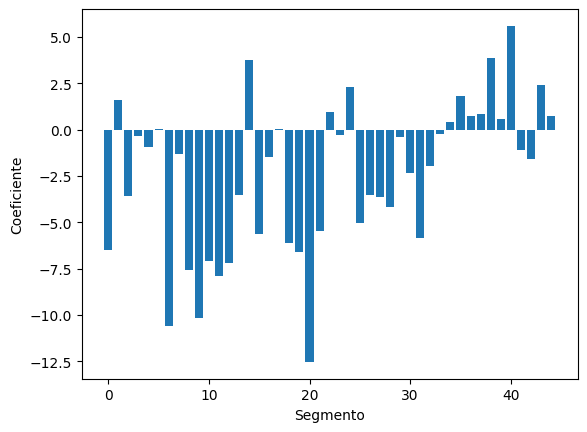

In [47]:
import matplotlib.pyplot as plt
plt.bar(np.arange(num_segments), segment_importance)
plt.xlabel('Segmento')
plt.ylabel('Coeficiente')
plt.savefig('./paper/images/slime.png')
plt.show()